# Objective:

Designing a 6/12/24 hours ahead water inflow forecast.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from operator import itemgetter
from typing import Union, List
from IPython.display import display
from ipywidgets import SelectMultiple, interact, IntProgress, IntSlider

from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit

from darts import TimeSeries
from darts.models import RegressionModel, XGBModel

from testing_functions import compute_errors, get_rmse, get_mape

## Modelling

Total number of usable samples 8095


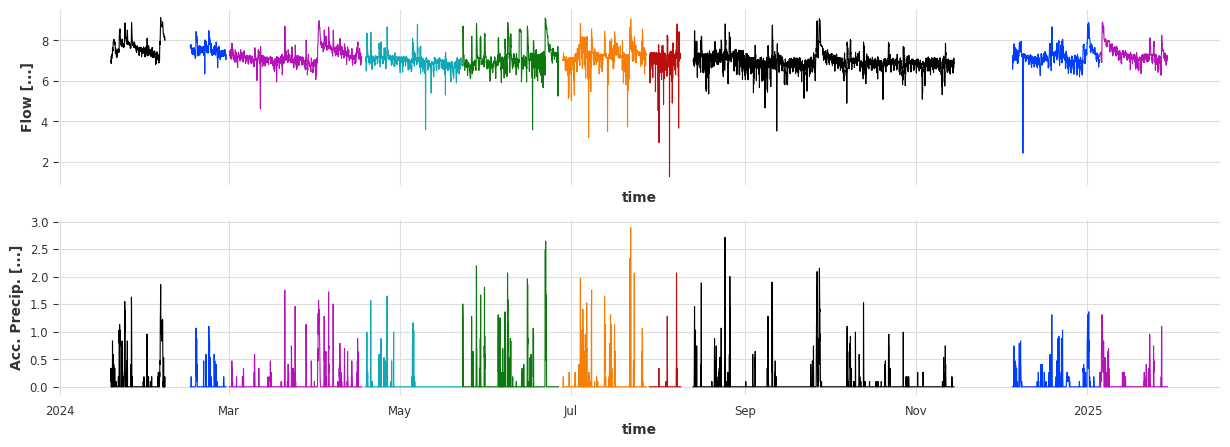

In [1]:
%run baseline.ipynb

train_getter: itemgetter = train_getter  # type: ignore # noqa: F821
test_getter: itemgetter = test_getter  # type: ignore # noqa: F821
target_subseries: List[TimeSeries] = target_subseries  # type: ignore # noqa: F821
poly_covariates: List[TimeSeries] = poly_covariates  # type: ignore # noqa: F821
expanded_covariates: List[TimeSeries] = expanded_covariates  # type: ignore # noqa: F821

output_chunk_length: int = output_chunk_length  # type: ignore # noqa: F821
df_baseline: pd.DataFrame = df_baseline  # type: ignore # noqa: F821

In [2]:
n_features = expanded_covariates[0].n_components
n_subseries = len(target_subseries)

n_ar_lags = 6
n_cov_lags = (6, 12)
n_lags = max(n_ar_lags, n_cov_lags[0])

train_target = train_getter(target_subseries)
test_target = test_getter(target_subseries)

train_future_covariates = train_getter(expanded_covariates)
test_future_covariates = test_getter(expanded_covariates)

### Candidate

In [5]:
encoders = {"cyclic": {"future": "month"}}

xgbmodel = XGBModel(
    lags=n_ar_lags,
    lags_future_covariates=n_cov_lags,
    output_chunk_length=output_chunk_length,
    add_encoders=encoders,
)

We define the `Model` class to better access the model and its estimator (will be used during feature selection).

In [6]:
class Model:
    def __init__(self, model: Union[RegressionModel, XGBModel]):
        self.model = model
        self.estimator = model.get_estimator(0, 0)


candidate = Model(xgbmodel)

Model supports multi-output; a single estimator forecasts all the horizons and components.


#### Feature selection
- In order to select features I run RFECV on every subseries. I will select the features that were selected in more than half of the subseries.

In [ ]:
pbar = IntProgress(min=0, max=len(train_target))
display(pbar)

original_future_components = train_future_covariates[0].components
used_features = np.zeros(n_features)

for target_i, covariates_i in zip(train_target, train_future_covariates):
    # Here, the estimator is not taking the past into account
    selector = RFECV(
        candidate.estimator,
        step=0.05,
        min_features_to_select=5,
        cv=TimeSeriesSplit(n_splits=4),
    )

    # The selection is made taking into account only the next time step
    selector = selector.fit(covariates_i.values(), target_i.values())
    used_features += selector.support_.astype(int)
    pbar.value += 1

# We only select features that have been selected in at least half of the subseries
index_relevant_features = [
    int(i) for i in np.where(used_features / n_subseries >= 0.5)[0]
]

selected_components = list(original_future_components[index_relevant_features])

print(len(selected_components))

IntProgress(value=0, max=9)

In [ ]:
selected_train_future_covariates = [
    s[selected_components] for s in train_future_covariates
]
selected_test_future_covariates = test_future_covariates[selected_components]

In [ ]:
# To avoid darts assigning lags to all my features, I initialize a new instance where
# I can cherry-pick which lags to assign to each future covariate
lagdict = {
    c: n_cov_lags for c in selected_components if c in poly_covariates[0].components
}
lagdict["default_lags"] = (0, 1)

new_xgb_model = XGBModel(
    lags=n_ar_lags,
    lags_future_covariates=lagdict,
    output_chunk_length=output_chunk_length,
    add_encoders=encoders,
)
new_candidate = Model(new_xgb_model)

new_candidate.model.fit(
    train_target,
    future_covariates=selected_train_future_covariates,
)

Model supports multi-output; a single estimator forecasts all the horizons and components.
Fitting was called with `add_encoders` and suspicion of lazy loading. The encodings/covariates are generated pre-train for all individual targets and loaded into memory. Depending on the size of your data, this can create memory issues. In case this applies, consider setting `add_encoders=None` at model creation.


XGBModel(lags=6, lags_past_covariates=None, lags_future_covariates={'feature_1': (6, 12), 'feature_10': (6, 12), 'feature_16': (6, 12), 'feature_23': (6, 12), 'feature_45': (6, 12), 'feature_50': (6, 12), 'feature_52': (6, 12), 'feature_57': (6, 12), 'feature_70': (6, 12), 'feature_74': (6, 12), 'feature_75': (6, 12), 'default_lags': (0, 1)}, output_chunk_length=12, output_chunk_shift=0, add_encoders={'cyclic': {'future': 'month'}}, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [ ]:
new_candidate.estimator.n_features_in_

216

Despite the number of selected features is relatively small, once we include their lags, the number of features greatly increases.

## Testing

In [ ]:
feature_i = SelectMultiple(
    options=selected_components,
    value=selected_components[:1],
    description="Features to compare",
)

nudger = IntSlider(min=-12, max=12, value=0, description="Nudge pred. start")


@interact(features=feature_i, nudge=nudger)
def plot_forecast(features, nudge):
    arbitrary_breakpoints = [400, 650, 750, 810, 968]  # Needs to be above n_lags
    fig, axes = plt.subplots(
        2, len(arbitrary_breakpoints), figsize=(20, 5), sharey="row", sharex="col"
    )
    for i, n_split in enumerate(arbitrary_breakpoints):
        time_axis = test_target.slice(
            test_target.time_index[n_split - n_lags],
            test_target.time_index[n_split + output_chunk_length],
        ).time_index
        minx = time_axis.min()
        maxx = time_axis.max()

        test_in, test_out = test_target.split_before(n_split + nudge)

        predicted_inflow = new_candidate.model.predict(
            series=test_in,
            n=output_chunk_length,
            future_covariates=selected_test_future_covariates,
        )

        actual_inflow = test_target.slice(start_ts=minx, end_ts=maxx)

        predicted_inflow.plot(label="predicted", ax=axes[0, i])
        actual_inflow.plot(label="actual", ax=axes[0, i])

        selected_test_future_covariates[list(features)].slice_intersect(
            actual_inflow
        ).plot(ax=axes[1, i])

        axes[0, i].axvline(x=test_out.time_index[0], c="red", linestyle="dashed")
        axes[1, i].axvline(x=test_out.time_index[0], c="red", linestyle="dashed")

        axes[0, i].set_xlim(minx, maxx)
        axes[1, i].set_xlim(minx, maxx)

    plt.tight_layout()


interactive(children=(SelectMultiple(description='Features to compare', index=(0,), options=('feature_1', 'fea…

- At every step of the test series, we forecast the next 24 hours and compare.

In [ ]:
candidate_errors = compute_errors(
    test_target,
    new_candidate.model,
    output_chunk_length,
    future_covariates=selected_test_future_covariates,
    output_transform=np.expm1,
)

In [ ]:
df_candidate = pd.DataFrame(
    {
        "RMSE": get_rmse(candidate_errors),
        "MAPE": get_mape(candidate_errors),
        "model": "xgb",
    }
)

In [ ]:
def assemble_comparison(candidates: List[pd.DataFrame]) -> pd.DataFrame:
    return (
        pd.concat(candidates, axis=0)
        .reset_index()
        .melt(id_vars=["lead_time", "model"], var_name="metric")
    )


comparison = assemble_comparison([df_baseline, df_candidate])

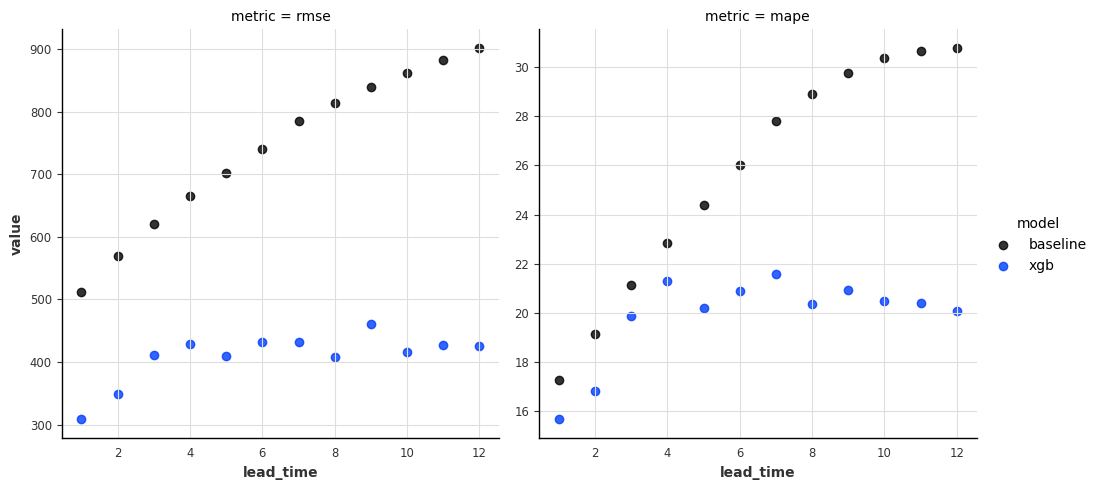

In [ ]:
sns.lmplot(
    data=comparison,
    x="lead_time",
    y="value",
    col="metric",
    hue="model",
    fit_reg=False,
    facet_kws=dict(sharey=False),
)